In [228]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from copy import deepcopy

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import brier_score_loss
from sklearn.pipeline import Pipeline
import joblib

import sys
import os
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

from databallpy.features.angle import get_smallest_angle
from databallpy.visualize import plot_soccer_pitch
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import make_scorer, brier_score_loss
brier_loss_scorer = make_scorer(brier_score_loss, greater_is_better=False, needs_proba=True)
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import Layout, interact, IntSlider, fixed

In [261]:
raw_data = pd.read_pickle("../data/all_shots2.pickle")
raw_data = raw_data[raw_data["shot_outcome"] != "own_goal"].copy()
raw_data["shot_outcome"] = raw_data["shot_outcome"].apply(lambda x: 1 if x=="goal" else 0)
raw_data = raw_data[raw_data["ball_goal_distance"] <= 53].copy()
raw_data.drop(columns=["event_id", "related_event_id", "created_oppertunity", "player_id", "period_id", "minutes", "seconds", "datetime", "start_x", "start_y", "team_id", "y_target", "z_target", "xG"], inplace=True)
raw_data.dropna(inplace=True)
raw_data.reset_index(drop=True, inplace=True)
raw_data["shot_outcome"] = raw_data["shot_outcome"].astype("category")
raw_data.shot_outcome.info()

<class 'pandas.core.series.Series'>
RangeIndex: 15900 entries, 0 to 15899
Series name: shot_outcome
Non-Null Count  Dtype   
--------------  -----   
15900 non-null  category
dtypes: category(1)
memory usage: 15.8 KB


In [262]:
data = raw_data.copy()

data["is_by_foot"] = data["body_part"].apply(lambda x: 1 if "foot" in x else 0)
data.drop(columns=["body_part"], inplace=True)

open_play_data = data[data["type_of_play"].isin(["regular_play", "corner_kick", "crossed_free_kick", "counter_attack"])]
foot_data = open_play_data[open_play_data["is_by_foot"] == 1].drop(columns=["type_of_play", "is_by_foot"])
head_data = open_play_data[open_play_data["is_by_foot"] == 0].drop(columns=["type_of_play", "is_by_foot"])

free_kick_data = data[data["type_of_play"]=="free_kick"].drop(columns=["type_of_play", "is_by_foot"])
free_kick_data = free_kick_data[free_kick_data["ball_goal_distance"] >=  16].copy()
penalty_data = data[data["type_of_play"]=="penalty"].drop(columns=["type_of_play", "is_by_foot"])
all_shots_data = data.drop(columns=["type_of_play", "is_by_foot"])
datasets = [foot_data, head_data, free_kick_data, all_shots_data]
dataset_names = ["Shots by foot", "Shots by head", "Shots by free kick", "All shots"]

In [263]:
def get_shot_angle(x:float, y:float) -> float:
    """Given a x, y coordinate, calculates the angle in degrees between 
    the vector from the ball to the left post and the vector form the ball 
    to the right post."""
    
    ball_xy = np.array([x, y])
    left_post_xy = np.array([53, 3.66])
    right_post_xy = np.array([53, -3.66])
    
    ball_left_post_vector = left_post_xy - ball_xy
    ball_right_post_vector = right_post_xy - ball_xy
    
    angle = get_smallest_angle(
            ball_left_post_vector, ball_right_post_vector, angle_format="degree"
    )
    return angle

def add_freq_ratio_plot(ax1, data, column, n_bins=30):
    bins = np.linspace(data[column].min(), data[column].max(), n_bins)
    hist_goal= np.histogram(data.loc[data["shot_outcome"]==1, column], bins=bins)[0]
    hist_all = np.clip(np.histogram(data[column], bins=bins)[0], a_min=1e-5, a_max=None)
    
    percentage_goals = hist_goal / hist_all
    ax1.hist(data.loc[data["shot_outcome"]==0, column], bins=n_bins, color="red", label="No goal")
    ax1.hist(data.loc[data["shot_outcome"]==1, column], bins=n_bins, color="green", alpha=0.8, label="Goal")
    ax1.set_xlabel(column)
    ax1.set_ylabel('Frequency')
    #ax1.legend(loc="upper left")
    ax1.set_title(col)
    
    ax2 = ax1.twinx()  
    ax2.plot(bins[:-1], percentage_goals, color="blue", label="Goal Ratio", alpha=0.5)
    # ax2.legend(loc="upper right")
    ax2.set_ylim((0.0, .75))
    return ax1, ax2

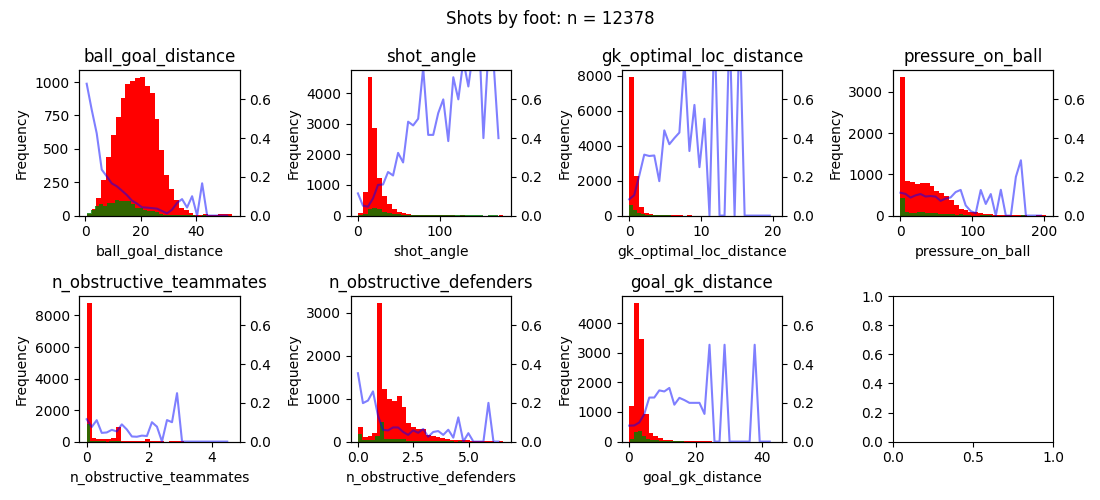

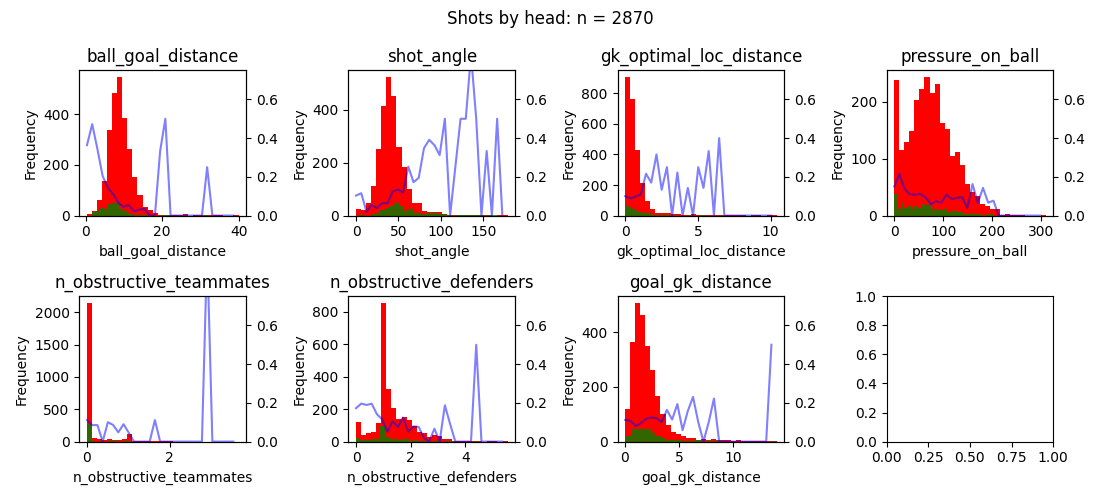

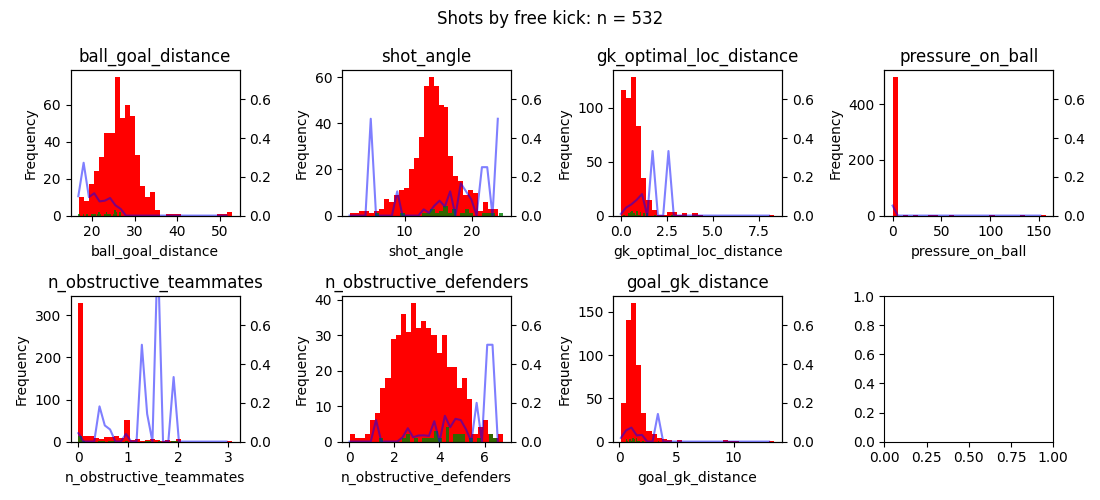

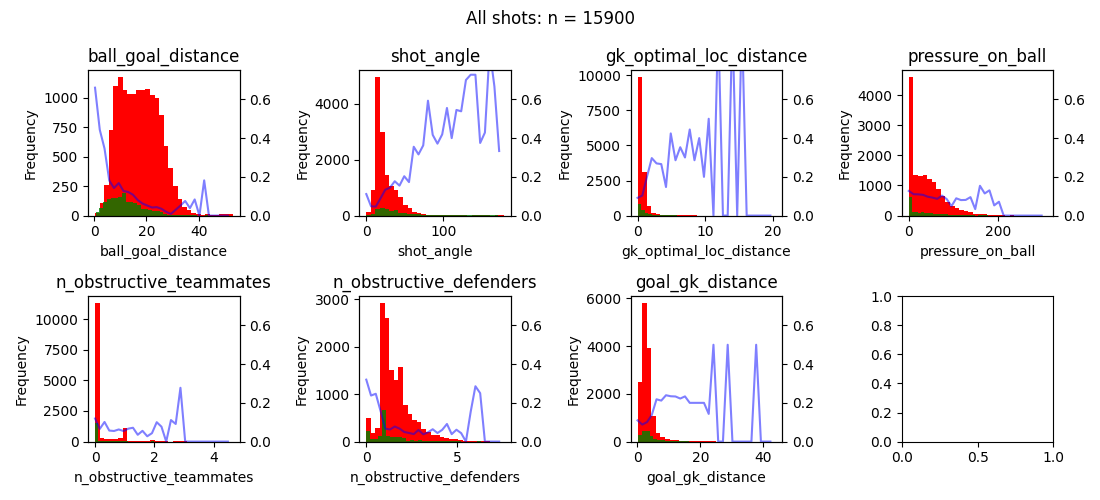

In [264]:
for dataset, name in zip(datasets, dataset_names):
    temp_data = dataset.copy()
    
    cols = temp_data.select_dtypes(include=[np.number]).columns
    n_plots = len(cols)
    n_rows = 2
    n_columns = int(np.ceil(n_plots / n_rows))
    fig, axes = plt.subplots(n_rows, n_columns, figsize=(11, 5)) 
    row = 0
    column = 0
    for col in cols:
        if col =="first_touch":
            continue
        if row == 2:
            
            print(col)
        ax1, ax2 = add_freq_ratio_plot(axes[row, column], temp_data, col)
        column += 1
        if column == n_columns:
            column = 0
            row += 1
    
    fig.suptitle(f"{name}: n = {len(dataset)}")
    fig.tight_layout()
    plt.show()

In [277]:
for dataset in datasets:
    dataset.drop(columns=["pressure_on_ball", "n_obstructive_teammates", "first_touch"], inplace=True)

head_data.drop(columns=["goal_gk_distance"], inplace=True)
free_kick_data.drop(columns=["n_obstructive_defenders"], inplace=True)

KeyError: "['pressure_on_ball', 'n_obstructive_teammates', 'first_touch'] not found in axis"

In [278]:
def create_scaler(series):
    return StandardScaler().fit(series.values.reshape(-1, 1))
    
def create_model(X, y, model, scalers, models, data_name):
    X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, stratify=y, random_state=42)
    X_train = pd.DataFrame(X_train, columns=X.columns)
    X_test = pd.DataFrame(X_test, columns=X.columns)
    X_test_all = np.zeros(X_test.shape)
    X_train_all = np.zeros(X_train.shape)

    for i, col in enumerate(X.columns):
        X_train_all[:, i] = scalers[col].transform(X_train[col].values.reshape(-1, 1))[:, 0]
        X_test_all[:, i] = scalers[col].transform(X_test[col].values.reshape(-1, 1))[:, 0]
    X_train_scaled = X_train_all
    X_test_scaled = X_test_all
    
    model.fit(X_train_scaled, y_train)
    models[str(model).split("(")[0]] = model
    
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    brier_loss = round(brier_score_loss(y_test, y_pred_proba), 3)
    print(f"For the {data_name} {str(model)}: Brier Score Loss: {brier_loss}")

all_models = {}
for dataset, name in zip(datasets, dataset_names):
    
    all_models[name] = {"scalers": {}}
    
    for col in dataset.columns:
        if col == "shot_outcome": continue
        all_models[name]["scalers"][col] = create_scaler(dataset[col])


monotonic_direction = {
    "ball_goal_distance": -1,
    "shot_angle": 1,
    "n_obstructive_defenders": -1,
    "goal_gk_distance": 0,
    "gk_optimal_loc_distance": 1,
    "sqrt_ball_goal_distance": -1,
}
for dataset, name in zip(datasets, dataset_names):
    all_models[name]["models"] =  {}
    models = [LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier()]
    constraints = [monotonic_direction[x] for x in dataset.columns if x != "shot_outcome"]
    hist_classifier = HistGradientBoostingClassifier(
        validation_fraction=0.2, 
        scoring=brier_loss_scorer, 
        monotonic_cst = constraints
    )
    models.append(hist_classifier)
    for model in models:
        create_model(dataset.drop(columns=["shot_outcome"]), dataset["shot_outcome"], model, all_models[name]["scalers"], all_models[name]["models"], name)

For the Shots by foot LogisticRegression(): Brier Score Loss: 0.081
For the Shots by foot DecisionTreeClassifier(): Brier Score Loss: 0.168
For the Shots by foot RandomForestClassifier(): Brier Score Loss: 0.082
For the Shots by foot HistGradientBoostingClassifier(monotonic_cst=[-1, 1, 1, -1, 0],
                               scoring=make_scorer(brier_score_loss, greater_is_better=False, needs_proba=True),
                               validation_fraction=0.2): Brier Score Loss: 0.081
For the Shots by head LogisticRegression(): Brier Score Loss: 0.088
For the Shots by head DecisionTreeClassifier(): Brier Score Loss: 0.179
For the Shots by head RandomForestClassifier(): Brier Score Loss: 0.091
For the Shots by head HistGradientBoostingClassifier(monotonic_cst=[-1, 1, 1, -1, 0],
                               scoring=make_scorer(brier_score_loss, greater_is_better=False, needs_proba=True),
                               validation_fraction=0.2): Brier Score Loss: 0.095
For the Shots by

interactive(children=(FloatSlider(value=1.0, description='Obstructive Defenders:', layout=Layout(width='50%'),…

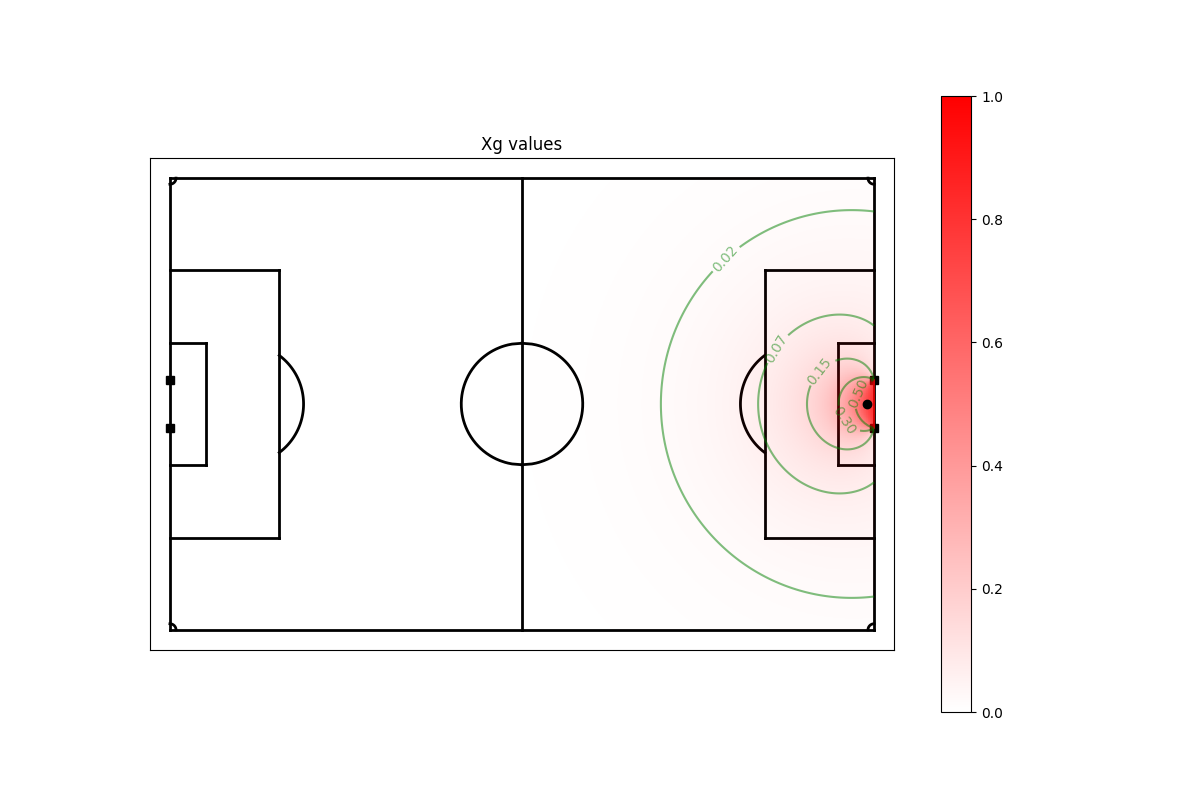

In [279]:
%matplotlib widget
x_range = np.linspace(0, 53, 200)  
y_range = np.linspace(-34, 34, 200)   
x, y = np.meshgrid(x_range, y_range)
goal_x, goal_y = 53, 0
ball_xy = np.dstack((x.reshape(-1, 1), y.reshape(-1, 1)))
goal_xy = np.array([goal_x, goal_y])
distance = np.sqrt((x - goal_x) ** 2 + (y - goal_y) ** 2)
angle = np.vectorize(get_shot_angle)(x, y)
distance_sqrt = np.sqrt(np.sqrt(distance))

colors = [(1, 0, 0, alpha) for alpha in np.linspace(0.001, 1.0, 256)]
custom_cmap = LinearSegmentedColormap.from_list('custom_red', colors)
fig, ax = plot_soccer_pitch(pitch_color="white")
ax.text(0, 0, "")
im = ax.imshow(np.zeros((200, 200)), extent=[0, 53, -34, 34], origin='lower', cmap=custom_cmap, vmin=0, vmax=1)
cax = fig.colorbar(im, ax=ax) 

style = {'description_width': 'initial'}
n_obstructive_defenders_slider = widgets.FloatSlider(
    value=1.,  
    min=0.,      
    max=11.,       
    step=0.1,      
    description='Obstructive Defenders:',
    layout=Layout(width="50%"),
    style=style,
)
gk_x_pos_slider = widgets.FloatSlider(
    value=52.0,
    min=30.0,
    max=54.0,
    step=0.1,
    description="Goalkeeper x position",
    layout=Layout(width="50%"),
    style=style,
)
gk_y_pos_slider = widgets.FloatSlider(
    value=0.0,
    min=-20.0,
    max=20.0,
    step=0.1,
    description="Goalkeeper y position",
    layout=Layout(width="50%"),
    style=style,
)

dataset_choice_dropdown = widgets.Dropdown(
    options=[x for x in dataset_names],
    value=dataset_names[0],
    description='Dataset:',
    disabled=False,
)

model_choice_dropdown = widgets.Dropdown(
    options=[x for x in all_models[dataset_choice_dropdown.value]["models"].keys()],
    value=[x for x in all_models[dataset_choice_dropdown.value]["models"].keys()][0],
    description='Model:',
    disabled=False,
)

@interact(n_obstructive_defenders=n_obstructive_defenders_slider, gk_x=gk_x_pos_slider, gk_y=gk_y_pos_slider, model = model_choice_dropdown, dataset=dataset_choice_dropdown)
def update_plot(n_obstructive_defenders, gk_x, gk_y, model, dataset):
    gk_goal_distance = np.sqrt((goal_x - gk_x)**2 + (goal_y - gk_y)**2)
    gk_xy = np.array([gk_x, gk_y])
    gk_optimal_loc_distance = np.linalg.norm(np.cross(goal_xy - ball_xy, ball_xy - gk_xy).reshape(-1, 1), axis=1) / np.linalg.norm(goal_xy - ball_xy)

    vars = {"ball_goal_distance": distance, 'shot_angle': angle, "gk_optimal_loc_distance": gk_optimal_loc_distance, 'n_obstructive_defenders':n_obstructive_defenders, "sqrt_ball_goal_distance": distance_sqrt, "goal_gk_distance": gk_goal_distance}
    scaled_vars = {}
    
    for key in vars.keys():
        if key in all_models[dataset]["scalers"].keys():
            scaler = all_models[dataset]["scalers"][key]
            var = vars[key]
            if isinstance(var, (int, float)):
                scaled_vars[key] = scaler.transform(np.array([var]).reshape(-1, 1))
            else:
                scaled_vars[key] = scaler.transform(var.reshape(-1, 1))
    
    X_features = np.zeros((len(x_range)*len(y_range), len(scaled_vars)))                    
    for i, feat in enumerate(scaled_vars.values()):
        if feat.shape == (1, 1):
            X_features[:, i] = np.full(len(X_features), feat)
        else:
            X_features[:, i] = feat[:, 0]

    model = all_models[dataset_choice_dropdown.value]["models"][model_choice_dropdown.value]
    xG_values = model.predict_proba(X_features)[:, 1]
    xG_matrix = xG_values.reshape(x.shape)
    if dataset == "Shots by free kick":
        xG_matrix[(x > 53-16) & (np.abs(y) < 20)] = np.nan
        
    [col.remove() for col in ax.collections]
    im.set_data(xG_matrix)
    contour = ax.contour(x, y, xG_matrix, colors='green', levels=[0.02, 0.07, 0.15, 0.3, 0.5], alpha = 0.5, linestyles='solid')
    ax.clabel(contour, inline=True, fontsize=10)
    ax.scatter([gk_x], [gk_y], color="black")
    ax.set_title("Xg values")

    fig.canvas.draw_idle()